# Data Extraction
A partir de um arquivo .xlsx, extrai a tabela contendo os números de cada sorteio.

In [1]:
%pip install ipython-autotime  --upgrade
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00
time: 785 µs (started: 2023-08-01 16:40:04 +00:00)


In [2]:
from google.colab import drive, files
import pandas as pd
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
time: 37.3 s (started: 2023-08-01 16:40:48 +00:00)


In [3]:
cols = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8', 'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15']
raffles = pd.read_excel("/content/drive/MyDrive/datasets/loterias/raw/lotofacil.xlsx", usecols=cols)
raffles.head()

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
0,2,3,5,6,9,10,11,13,14,16,18,20,23,24,25
1,1,4,5,6,7,9,11,12,13,15,16,19,20,23,24
2,1,4,6,7,8,9,10,11,12,14,16,17,20,23,24
3,1,2,4,5,8,10,12,13,16,17,18,19,23,24,25
4,1,2,4,8,9,11,12,13,15,16,19,20,23,24,25


time: 2.16 s (started: 2023-08-01 16:41:27 +00:00)


# Data Transformation
A partir da tabela que contém os sorteios, cria uma segunda contendo dados estatísticos e outras informações adicionais sobre os sorteios. Esta etapa será o equivalente à engenharia de atributos, mas ao contrário do que é feito normalmente, será feita antes da análise exploratória porque o conjunto de dados precisa ser criado primeiro.

In [4]:
from sklearn.base     import BaseEstimator, TransformerMixin
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

import itertools
import numpy as np

time: 913 ms (started: 2023-08-01 16:41:29 +00:00)


In [5]:
class DescriptiveStatistics(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_ = X.copy()
    X_['min']  = X_.apply(lambda y: y.min(), axis=1)
    X_['max']  = X_.apply(lambda y: y.max(), axis=1)
    X_['mean'] = X_.apply(lambda y: y.mean(), axis=1)
    X_['std']  = X_.apply(lambda y: y.std(), axis=1)
    return X_

time: 1.7 ms (started: 2023-08-01 16:41:30 +00:00)


In [6]:
class EvenAmount(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def even_amount(self, raffle):
    raffle_size = 15
    even = itertools.filterfalse(lambda x: x % 2 != 0, raffle.iloc[:raffle_size])
    return len(list(even))

  def transform(self, X, y=None):
    X = X.copy()
    raffle_size = 15
    X['even_amount'] = X.apply(self.even_amount, axis=1)
    return X

time: 1.25 ms (started: 2023-08-01 16:41:30 +00:00)


In [7]:
class Quartiles(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X_ = X.iloc[:, 0: 15].copy()
    X['quartile_1_9']   = X_.apply(lambda y: ((y >= 1) & (y <= 9)).sum(), axis=1)
    X['quartile_10_17']  = X_.apply(lambda y: ((y >= 10) & (y <= 17)).sum(), axis=1)
    X['quartile_18_25'] = X_.apply(lambda y: ((y >= 18) & (y <= 25)).sum(), axis=1)
    return X

time: 1.35 ms (started: 2023-08-01 16:41:30 +00:00)


In [8]:
class RaffleRemover(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    return X.iloc[:, 15:]

time: 963 µs (started: 2023-08-01 16:41:30 +00:00)


In [9]:
class RepeatedOne(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def match_numbers(self, X):
      raffle_x = set(X[['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Bola7', 'Bola8', 'Bola9', 'Bola10', 'Bola11', 'Bola12', 'Bola13', 'Bola14', 'Bola15']])
      raffle_y = set(X[['lag1_Bola1', 'lag1_Bola2', 'lag1_Bola3', 'lag1_Bola4', 'lag1_Bola5', 'lag1_Bola6', 'lag1_Bola7', 'lag1_Bola8', 'lag1_Bola9', 'lag1_Bola10', 'lag1_Bola11', 'lag1_Bola12', 'lag1_Bola13', 'lag1_Bola14', 'lag1_Bola15']])
      return len(raffle_x.intersection(raffle_y))

  def transform(self, X, y=None):
    X_ = X.copy()
    for name in X_.columns:
      X_['lag1_' + name] = X_[name].shift(1)
    X['repeated'] = X_.apply(self.match_numbers, axis=1)
    return X

time: 2.1 ms (started: 2023-08-01 16:41:30 +00:00)


In [10]:
class QuartilesPatternMapping(BaseEstimator, TransformerMixin):
  """
  Codifica cada sequência de valores presentes nos atributos quartile_1_5 até quartile_21_25 em apenas um número.
  Assim, é possível criar um atributo substituindo os cinco.
  """
  def fit(self, X, y=None):
    X_ = X[['quartile_1_9', 'quartile_10_17', 'quartile_18_25']]
    self.quartiles = list()
    X_.apply(lambda y: self.quartiles.append(np.array2string(y.to_numpy())), axis=1) # transforma cada sequência de cinco números em uma string
    patterns_unique = {item for item in self.quartiles} # set comprehension
    self.patterns_map = {value: index for index, value in enumerate(patterns_unique)} # dicionário padrão:id
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X['quartiles_codified'] = pd.Series(self.quartiles).replace(self.patterns_map)
    X = X.drop(['quartile_1_9', 'quartile_10_17', 'quartile_18_25'], axis=1)
    return X

time: 1.5 ms (started: 2023-08-01 16:41:31 +00:00)


## Pipeline completo

In [11]:
steps = [('descriptivestatistics', DescriptiveStatistics()),
         ('repeated', RepeatedOne()),
         ('evenodd', EvenAmount()),
         ('quartiles', Quartiles()),
         ('raffleremover', RaffleRemover()),
         ('quartilespatternmapping', QuartilesPatternMapping())]

pipeline_full = Pipeline(steps=steps)
dataset = pipeline_full.fit_transform(raffles)

time: 8.55 s (started: 2023-08-01 16:41:35 +00:00)


# EDA

In [12]:
dataset

,min,max,mean,std,repeated,even_amount,quartiles_codified
0,2,25,13.294118,7.954020,0,8,44
1,1,24,12.352941,7.561055,9,6,35
2,1,24,12.176471,7.334329,11,9,10
3,1,25,13.117647,8.344652,9,8,44
4,1,25,13.411765,8.189368,11,7,44
...,...,...,...,...,...,...,...
2871,1,25,13.823529,8.082190,10,6,43
2872,1,25,14.588235,7.889374,10,9,19
2873,1,23,11.588235,7.178881,7,6,35
2874,1,25,11.176471,7.350352,10,7,18


time: 15.3 ms (started: 2023-08-01 16:41:43 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   min                 2876 non-null   int64  
 1   max                 2876 non-null   int64  
 2   mean                2876 non-null   float64
 3   std                 2876 non-null   float64
 4   repeated            2876 non-null   int64  
 5   even_amount         2876 non-null   int64  
 6   quartiles_codified  2876 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 157.4 KB
time: 12.6 ms (started: 2023-08-01 13:23:15 +00:00)


In [ ]:
dataset.describe()

,min,max,mean,std,repeated,even_amount,quartiles_codified
count,2876.000000,2876.00000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,1.621349,24.40299,13.018776,7.735939,8.960014,7.196801,20.899166
std,0.924008,0.93770,1.085323,0.550401,1.237726,1.255057,12.446236
min,1.000000,18.00000,8.941176,5.093588,0.000000,3.000000,0.000000
25%,1.000000,24.00000,12.294118,7.393886,8.000000,6.000000,8.000000
50%,1.000000,25.00000,13.000000,7.784511,9.000000,7.000000,20.500000
75%,2.000000,25.00000,13.823529,8.138613,10.000000,8.000000,33.000000
max,7.000000,25.00000,16.294118,9.257560,14.000000,11.000000,45.000000


time: 28.6 ms (started: 2023-08-01 13:23:16 +00:00)


In [13]:
dataset.nunique()

min                      7
max                      8
mean                   108
std                   1849
repeated                11
even_amount              9
quartiles_codified      46
dtype: int64

time: 11.2 ms (started: 2023-08-01 16:41:51 +00:00)


## Data Visualization

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()
%matplotlib inline

time: 315 ms (started: 2023-08-01 16:41:54 +00:00)


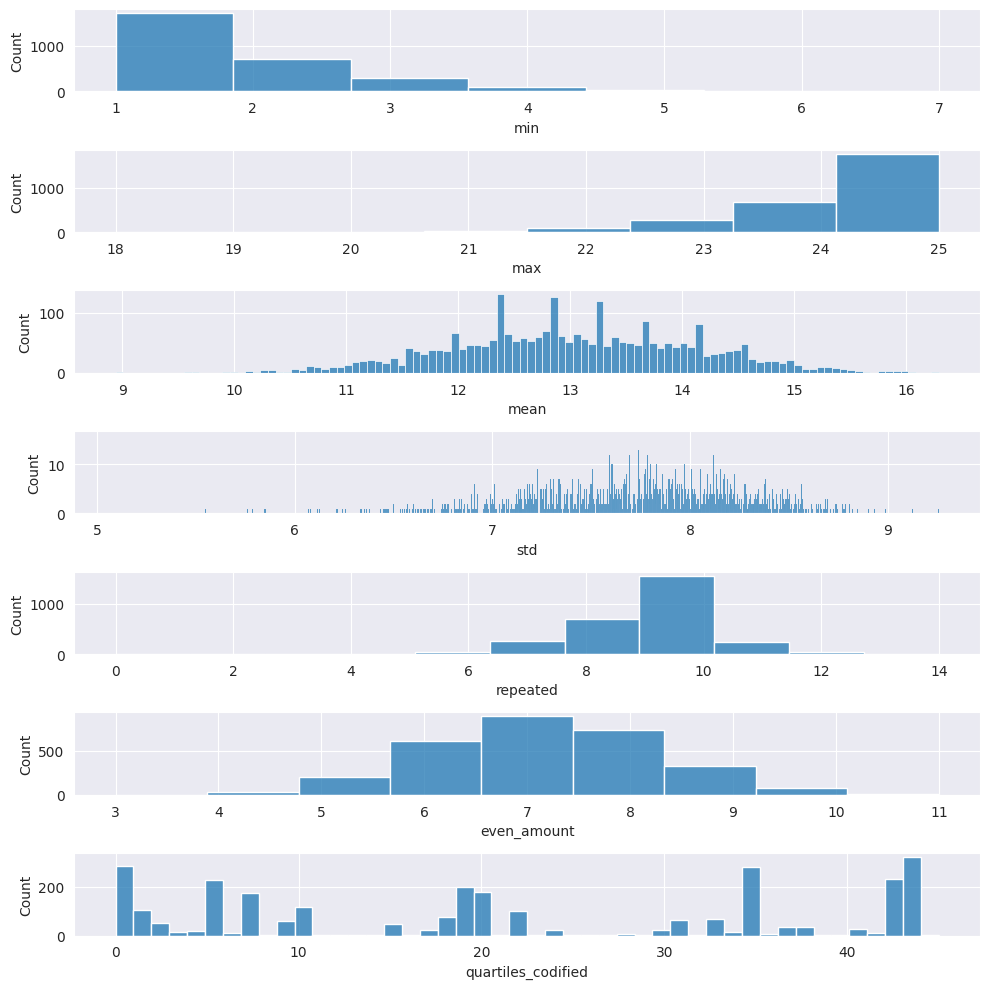

time: 5.09 s (started: 2023-08-01 16:41:55 +00:00)


In [15]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(7, 1, figsize=(10, 10))
for axis, col_name in zip(ax.ravel(), dataset.columns):
  sns.histplot(data=dataset, x=col_name, bins=dataset[col_name].nunique(), ax=axis)
plt.tight_layout()
plt.show()

# Train/Test Split

In [16]:
from sklearn.model_selection import TimeSeriesSplit

time: 102 ms (started: 2023-08-01 16:42:00 +00:00)


In [17]:
tss = TimeSeriesSplit(n_splits=2, test_size=200, gap=1)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]

time: 3.3 ms (started: 2023-08-01 16:42:01 +00:00)


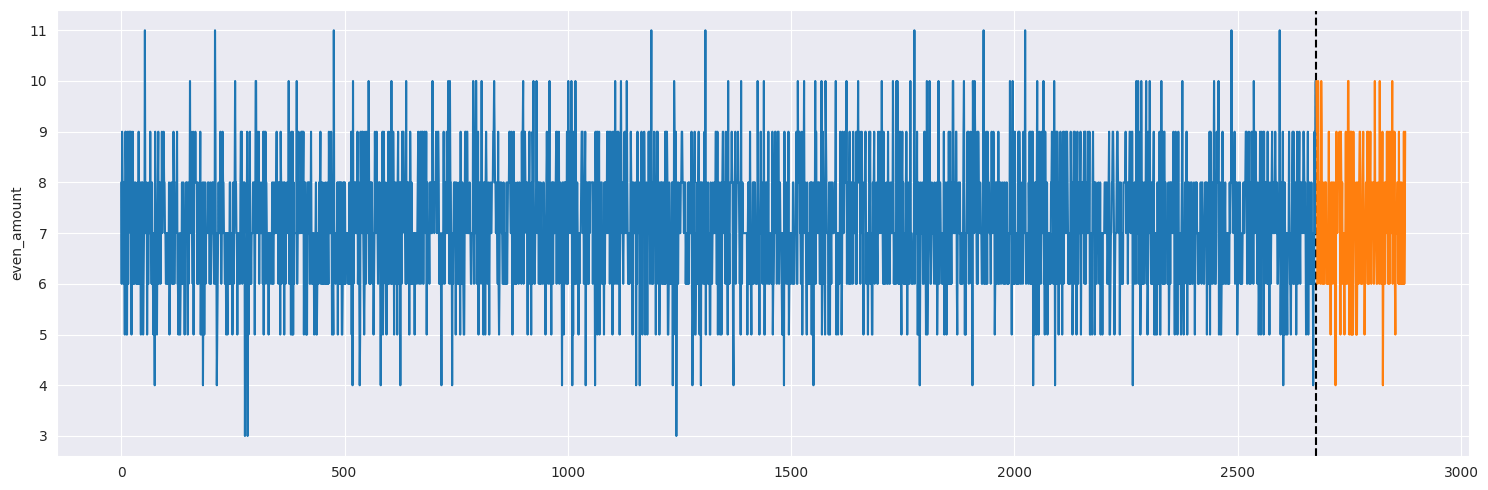

time: 735 ms (started: 2023-08-01 16:42:01 +00:00)


In [18]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.lineplot(x=train_set.index, y=train_set['even_amount'], ax=axs)
sns.lineplot(x=test_set.index, y=test_set['even_amount'], ax=axs)

plt.tight_layout()
plt.show()

# Data Labeling

In [19]:
from scipy.stats import mode

time: 526 µs (started: 2023-08-01 16:42:07 +00:00)


In [20]:
def lag_window_features(ds, feature_name):
  ds = ds.copy()
  cat = ['min', 'max', 'repeated', 'even_amount', 'quartiles_codified']
  num = ['mean', 'std']
  week = 5 # apenas dias úteis
  ds['lag_' + feature_name] = ds[feature_name].shift(1)
  ds['fwd_' + feature_name] = ds[feature_name].shift(-1)
  if feature_name in cat:
    ds['wind_' + str(week) + '_' + feature_name] = ds[feature_name].rolling(window=week).apply(lambda x: mode(x, keepdims=True)[0])
  else:
    ds['wind_' + str(week) + '_' + feature_name] = ds[feature_name].rolling(window=week).mean()
  ds = ds.dropna()
  return ds



def create_labels(ds, feature_name):
  ds = lag_window_features(ds, feature_name)
  label_name = 'fwd_' + feature_name
  y = ds[label_name]
  X = ds.drop(label_name, axis=1)
  return X, y

time: 1.43 ms (started: 2023-08-01 16:42:17 +00:00)


In [21]:
label_name = 'repeated'
X_train, y_train  = create_labels(train_set, label_name)
X_test, y_test    = create_labels(test_set, label_name)

time: 873 ms (started: 2023-08-01 16:42:19 +00:00)


# Model Training

In [22]:
from datetime                     import datetime
from sklearn.ensemble             import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics              import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.multioutput          import MultiOutputClassifier
from sklearn.utils.class_weight   import compute_class_weight
from keras.callbacks              import EarlyStopping, ReduceLROnPlateau
from keras.layers                 import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.models                 import Sequential, Model
from keras.optimizers             import Nadam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.wrappers.scikit_learn  import KerasClassifier
from prophet                      import Prophet
import lightgbm as lgb

time: 4.08 s (started: 2023-08-01 16:42:21 +00:00)


Class Weights Computing

In [23]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {key:value for key, value in zip(classes, weights)}
print(class_weights)

{5.0: 267.0, 6.0: 6.675, 7.0: 1.068, 8.0: 0.40271493212669685, 9.0: 0.3065442020665901, 10.0: 0.459552495697074, 11.0: 1.2535211267605635, 12.0: 6.209302325581396, 13.0: 38.142857142857146, 14.0: 267.0}
time: 6.71 ms (started: 2023-08-01 16:42:25 +00:00)


Class Mapping

In [24]:
tr_classes  = set(np.unique(y_train))
te_classes  = set(np.unique(y_test))
all_classes = (tr_classes | te_classes)

class_mapping    = {value:key for key, value in enumerate(all_classes)}
class_mapping_rw = {key:value for key, value in enumerate(all_classes)}

time: 1.94 ms (started: 2023-08-01 16:42:25 +00:00)


### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
print(f'accuracy score: {accuracy_score(y_train, y_pred):.2f}')
print(classification_report(y_train, y_pred))

accuracy score: 1.00
              precision    recall  f1-score   support

         5.0       1.00      1.00      1.00         1
         6.0       1.00      1.00      1.00        40
         7.0       1.00      1.00      1.00       250
         8.0       1.00      1.00      1.00       663
         9.0       1.00      1.00      1.00       871
        10.0       1.00      1.00      1.00       581
        11.0       1.00      1.00      1.00       213
        12.0       1.00      1.00      1.00        43
        13.0       1.00      1.00      1.00         7
        14.0       1.00      1.00      1.00         1

    accuracy                           1.00      2670
   macro avg       1.00      1.00      1.00      2670
weighted avg       1.00      1.00      1.00      2670

time: 560 ms (started: 2023-08-01 13:25:20 +00:00)


### LightGBM

In [25]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print(f'accuracy score: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

accuracy score: 0.30
              precision    recall  f1-score   support

         6.0       0.00      0.00      0.00         3
         7.0       0.20      0.06      0.09        18
         8.0       0.25      0.33      0.29        43
         9.0       0.40      0.45      0.42        69
        10.0       0.23      0.35      0.28        34
        11.0       0.20      0.05      0.07        22
        12.0       0.00      0.00      0.00         6

    accuracy                           0.30       195
   macro avg       0.18      0.18      0.16       195
weighted avg       0.28      0.30      0.28       195

time: 857 ms (started: 2023-08-01 16:42:33 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RNN

### LSTM
Reshaping train/test sets.

In [40]:
X_train_lstm = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm  = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_lstm = y_train.replace(to_replace=class_mapping)
y_test_lstm  = y_test.replace(to_replace=class_mapping)

time: 5.7 ms (started: 2023-08-01 17:29:18 +00:00)


Definindo as callbacks.

In [57]:
#callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

time: 657 µs (started: 2023-08-01 17:39:11 +00:00)


In [ ]:
output_size  = len(np.unique(y_train_lstm))
extra_output = len(np.setdiff1d(np.unique(y_test), np.unique(y_train)))
print(f'output size: {output_size + extra_output}')

nn = Sequential()
nn.add(LSTM(units=300, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
nn.add(LSTM(units=300, activation='relu', return_sequences=True))
nn.add(LSTM(units=300, activation='relu'))
nn.add(Dense(units=output_size + extra_output, activation='softmax'))

nn.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nn.fit(X_train_lstm, y_train_lstm,
       validation_data=(X_test_lstm, y_test_lstm), epochs=2,
       callbacks=[early_stopping_cb, lr_performance], verbose=True)

output size: 10
Epoch 1/2
84/84 [==============================] - 23s 179ms/step - loss: 1.6938 - accuracy: 0.2993 - val_loss: 1.6593 - val_accuracy: 0.3538 - lr: 0.0010
Epoch 2/2
84/84 [==============================] - 10s 125ms/step - loss: 1.6416 - accuracy: 0.3225 - val_loss: 1.6639 - val_accuracy: 0.3538 - lr: 0.0010


time: 34.9 s (started: 2023-08-01 13:34:17 +00:00)


### LSTM Alternative

In [41]:
y_train_lstm = y_train.replace(to_replace=class_mapping)
y_test_lstm  = y_test.replace(to_replace=class_mapping)

y_train_rob = y_train_lstm.tolist()
y_test_rob  = y_test_lstm.tolist()

X_train_rob = X_train.to_numpy().tolist()
X_test_rob  = X_test.to_numpy().tolist()

time: 9.37 ms (started: 2023-08-01 17:29:27 +00:00)


In [54]:
wdw_length = 7
tsg_train = TimeseriesGenerator(X_train_rob, y_train_rob, length=wdw_length, sampling_rate=1, stride=1, batch_size=32)
tsg_test  = TimeseriesGenerator(X_test_rob, y_test_rob, length=wdw_length, sampling_rate=1, stride=1, batch_size=32)

time: 885 µs (started: 2023-08-01 17:38:27 +00:00)


In [58]:
output_size  = len(np.unique(y_train_lstm))
extra_output = len(np.setdiff1d(np.unique(y_test), np.unique(y_train)))
print(f'output size: {output_size + extra_output}')

nn = Sequential()
nn.add(LSTM(units=300, activation='relu', return_sequences=True, input_shape=(wdw_length, X_train.shape[1])))
nn.add(LSTM(units=300, activation='relu', return_sequences=True))
nn.add(LSTM(units=300, activation='relu'))
nn.add(Dense(units=output_size + extra_output, activation='softmax'))

nn.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

nn.fit(tsg_train,
       validation_data=tsg_test, epochs=2,
       callbacks=[early_stopping_cb, lr_performance], verbose=True)

output size: 10
Epoch 1/2
84/84 [==============================] - 19s 156ms/step - loss: 1.7702 - accuracy: 0.2880 - val_loss: 1.6849 - val_accuracy: 0.2234 - lr: 0.0010
Epoch 2/2
84/84 [==============================] - 13s 149ms/step - loss: 1.6479 - accuracy: 0.3027 - val_loss: 1.7139 - val_accuracy: 0.3511 - lr: 0.0010


time: 32.1 s (started: 2023-08-01 17:39:19 +00:00)


### CNN

datetime.datetime(2023, 7, 30, 18, 28, 40, 803614)

time: 10.9 ms (started: 2023-07-30 18:28:40 +00:00)


### Prophet
Antes, preciso adaptar os conjuntos de treinamento e teste para o modelo da Meta. Primeiro, preciso unir as labels com os conjuntos de dados criando dois novos conjuntos, train_set_prophet e test_set_prophet. Depois, vou criar um atributo contendo datas e chamá-lo de 'ds'. Neste caso, vou criar uma sequência de datas com frequência diária do tamanho do conjunto de treinamento e teste. A última etapa é renomear a label para 'y'.

In [ ]:
train_set_prophet = pd.concat([X_train, y_train], axis=1)
test_set_prophet = pd.concat([X_test, y_test], axis=1)

today = datetime.today()

days_amount = len(train_set_prophet.index)
train_set_prophet['ds'] = pd.date_range(end=today, periods=days_amount, freq='D')

days_amount = len(test_set_prophet.index)
test_set_prophet['ds'] = pd.date_range(end=today, periods=days_amount, freq='D')

train_set_prophet.rename(columns={y_train.name:'y'}, inplace=True)
test_set_prophet.rename(columns={y_test.name:'y'}, inplace=True)

train_set_prophet.head()

,min,max,mean,std,repeated,even_amount,quartiles_codified,lag_min,wind_5_min,y,ds
4,1,25,13.411765,8.189368,11,7,25,1.0,1.0,1.0,2016-04-08 18:41:53.788375
5,1,25,12.294118,8.251664,9,6,33,1.0,1.0,1.0,2016-04-09 18:41:53.788375
6,1,25,14.176471,7.762923,11,8,19,1.0,1.0,1.0,2016-04-10 18:41:53.788375
7,1,25,13.529412,7.492095,9,7,25,1.0,1.0,3.0,2016-04-11 18:41:53.788375
8,3,25,14.117647,7.435071,10,5,30,1.0,1.0,2.0,2016-04-12 18:41:53.788375


time: 22.8 ms (started: 2023-07-30 18:41:53 +00:00)


In [ ]:
pro = Prophet()
pro.fit(train_set_prophet)
y_pred = pro.predict(train_set_prophet)
score = np.sqrt(mean_squared_error(train_set_prophet['y'], y_pred['yhat']))
print(f'\n\nmean_squared error: {score:.2f}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6mxwd28/44jwkfj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6mxwd28/zkazdexv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94782', 'data', 'file=/tmp/tmpo6mxwd28/44jwkfj8.json', 'init=/tmp/tmpo6mxwd28/zkazdexv.json', 'output', 'file=/tmp/tmpo6mxwd28/prophet_model8r2fn08a/prophet_model-20230730185312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




mean_squared error: 0.92
time: 1.5 s (started: 2023-07-30 18:53:12 +00:00)
